In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import logging
from sklearn.manifold import TSNE
import umap

## Dataset

For this project, we will use the [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/) dataset. It contains reviews of fine foods from Amazon, including text reviews and ratings. Here's the list of columns in the dataset:

- `Id`: Unique identifier for each review
- `ProductId`: Unique identifier for the product
- `UserId`: Unique identifier for the user
- `ProfileName`: Name of the user profile
- `HelpfulnessNumerator`: Number of helpful votes
- `HelpfulnessDenominator`: Total number of votes
- `Score`: Rating given by the user (1 to 5)
- `Time`: Timestamp of the review
- `Summary`: Summary of the review
- `Text`: Full text of the review

In [2]:
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

True

In [3]:
logger = logging.getLogger(__name__)
random_state = 42
dataset_sample_size = 10000

In [4]:

from typing import List, Union
import html
import re
class WordTokenizer:
    """
    A class for tokenizing and preprocessing text data using NLTK.
    This class handles text normalization, punctuation removal, and optional stop word filtering.

    Attributes:
        remove_stopwords (bool): Whether to remove stop words.
        lower_case (bool): Whether to convert text to lowercase.
    """

    def __init__(
        self,
        remove_stopwords: bool = True,
        lower_case: bool = True,
        use_lemmatization: bool = True,
        replace_repeated_chars: bool = True,
    ):
        self.remove_stopwords = remove_stopwords
        self.lower_case = lower_case
        self.lematizer = nltk.WordNetLemmatizer() if use_lemmatization else None
        self.stop_words = set(stopwords.words("english")) if remove_stopwords else set()
        self.replace_repeated_chars = replace_repeated_chars

    def process(
        self, text: Union[str, List[str]], return_tokens: bool = False
    ) -> Union[str, List[str]]:
        """
        Process the input text by cleaning, normalizing, and optionally removing stop words.

        Args:
            text (str | List[str]): The input text. If a list is provided, its elements will be joined into a single string.
            return_tokens (bool): If True, returns a list of tokens instead of a string.

        Returns:
            str | List[str]: The processed text as a string or list of tokens.
        """
        if not text:
            return [] if return_tokens else ""
        logger.debug(f"Processing text: {text}")

        text_str = " ".join(map(str, text)) if isinstance(text, list) else str(text)

        text = self._clean_text(text_str)
        logger.debug(f"Cleaned text: {text}")

        tokens = self._tokenize(text)
        logger.debug(f"Tokenized text: {tokens}")

        tokens = self._remove_stopwords(tokens)
        logger.debug(f"Tokens after stop word removal: {tokens}")

        tokens = self._apply_lemmatization(tokens)
        logger.debug(f"Tokens after lemmatization: {tokens}")

        tokens = [token for token in tokens if token]  # Remove empty tokens

        logger.debug(f"Final tokens: {tokens}")

        return tokens if return_tokens else " ".join(tokens)

    def _clean_text(self, text: str) -> str:
        if self.lower_case:
            text = text.lower()

        text = html.unescape(text)  # decode &amp; and other HTML entities
        text = text.strip().replace("\n", " ").replace("\r", " ")
        text = re.sub(r"<[^>]*>", "", text)  # Remove HTML tags
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
        text = self._fix_contractions(text)  # Fix common contractions

        # reduce repeated characters like "sooo good" to "so good" or "loooove" to "love"
        if self.replace_repeated_chars:
            text = re.sub(r"(.)\1{2,}", r"\1\1", text)

        return text

    def _apply_lemmatization(self, tokens: List[str]) -> List[str]:
        if self.lematizer is not None:
            tokens = [self.lematizer.lemmatize(token) for token in tokens]
        return tokens

    def _tokenize(self, text: str) -> List[str]:
        return word_tokenize(text)

    def _remove_stopwords(self, tokens: List[str]) -> List[str]:
        if self.remove_stopwords:
            tokens = self._remove_stop_words(tokens)
        return tokens

    def _remove_stop_words(self, tokens: List[str]) -> List[str]:
        return [word for word in tokens if word not in self.stop_words]

    def _fix_contractions(self, text: str) -> str:
        contraction_map = {
            "dont": "do not",
            "cant": "can not",
            "wont": "will not",
            "isnt": "is not",
            "arent": "are not",
            "wasnt": "was not",
            "werent": "were not",
            "didnt": "did not",
            "doesnt": "does not",
            "havent": "have not",
            "hasnt": "has not",
            "hadnt": "had not",
            "shouldnt": "should not",
            "wouldnt": "would not",
            "couldnt": "could not",
            "mustnt": "must not",
            "mightnt": "might not",
            "neednt": "need not",
            "im": "i am",
            "ive": "i have",
            "ill": "i will",
            "id": "i would",
            "youre": "you are",
            "youve": "you have",
            "youll": "you will",
            "youd": "you would",
            "theyre": "they are",
            "theyve": "they have",
            "theyll": "they will",
            "theyd": "they would",
            "weve": "we have",
            "theres": "there is",
            "heres": "here is",
            "thats": "that is",
            "whats": "what is",
            "whos": "who is",
            "don't": "do not",
            "can't": "can not",
            "won't": "will not",
            "isn't": "is not",
            "aren't": "are not",
            "wasn't": "was not",
            "weren't": "were not",
            "didn't": "did not",
            "doesn't": "does not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "shouldn't": "should not",
            "wouldn't": "would not",
            "couldn't": "could not",
            "mustn't": "must not",
            "mightn't": "might not",
            "needn't": "need not",
            "i'm": "i am",
            "i've": "i have",
            "i'll": "i will",
            "i'd": "i would",
            "you're": "you are",
            "you've": "you have",
            "you'll": "you will",
            "you'd": "you would",
            "they're": "they are",
            "they've": "they have",
            "they'll": "they will",
            "they'd": "they would",
            "we've": "we have",
        }
        for contraction, full_form in contraction_map.items():
            text = re.sub(r"\b" + re.escape(contraction) + r"\b", full_form, text)
        return text

    def __call__(
        self, text: Union[str, List[str]], return_tokens: bool = False
    ) -> Union[str, List[str]]:
        """
        Allow the object to be called like a function.

        Example:
            tokenizer = WordTokenizer()
            clean_text = tokenizer("Some input text here.")
        """
        return self.process(text, return_tokens=return_tokens)


In [5]:
# Uncomment this line if you have a pre-vectorized or pre-tokenized dataset and use it instead of the next line.
# df = pd.read_csv("./data/vectorized_reviews.csv") 

df = pd.read_csv("./data/Reviews.csv")
if dataset_sample_size > 0:
    df = df.sample(n=dataset_sample_size, random_state=random_state)

In [6]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...
...,...,...,...,...,...,...,...,...,...,...
477825,477826,B004UC0GIU,A17OE0VPF9FO97,Norman D. Lund,7,7,4,1325721600,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an..."
414355,414356,B001ELJK78,A1Y4DROW97OXL4,Toivo,2,2,4,1262649600,Pleasantly suprised,I ordered this kit just to try it since the pr...
553964,553965,B001E5E0D8,A2XSQDY34DMXTA,"SMA ""SA""",0,0,5,1248739200,Super coffee,This espresso is amazing. My wife would not dr...
471038,471039,B002HN2BM8,A2KGOD6XKLW2J8,"M. Morse ""Dita""",0,0,5,1311292800,Sweet!,I was so happy when I decided to look for Runt...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 165256 to 410291
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 9999 non-null   object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 859.4+ KB


In [8]:
grouped_by_product = df.groupby("ProductId").size().sort_values(ascending=False)
grouped_by_user = df.groupby("UserId").size().sort_values(ascending=False)

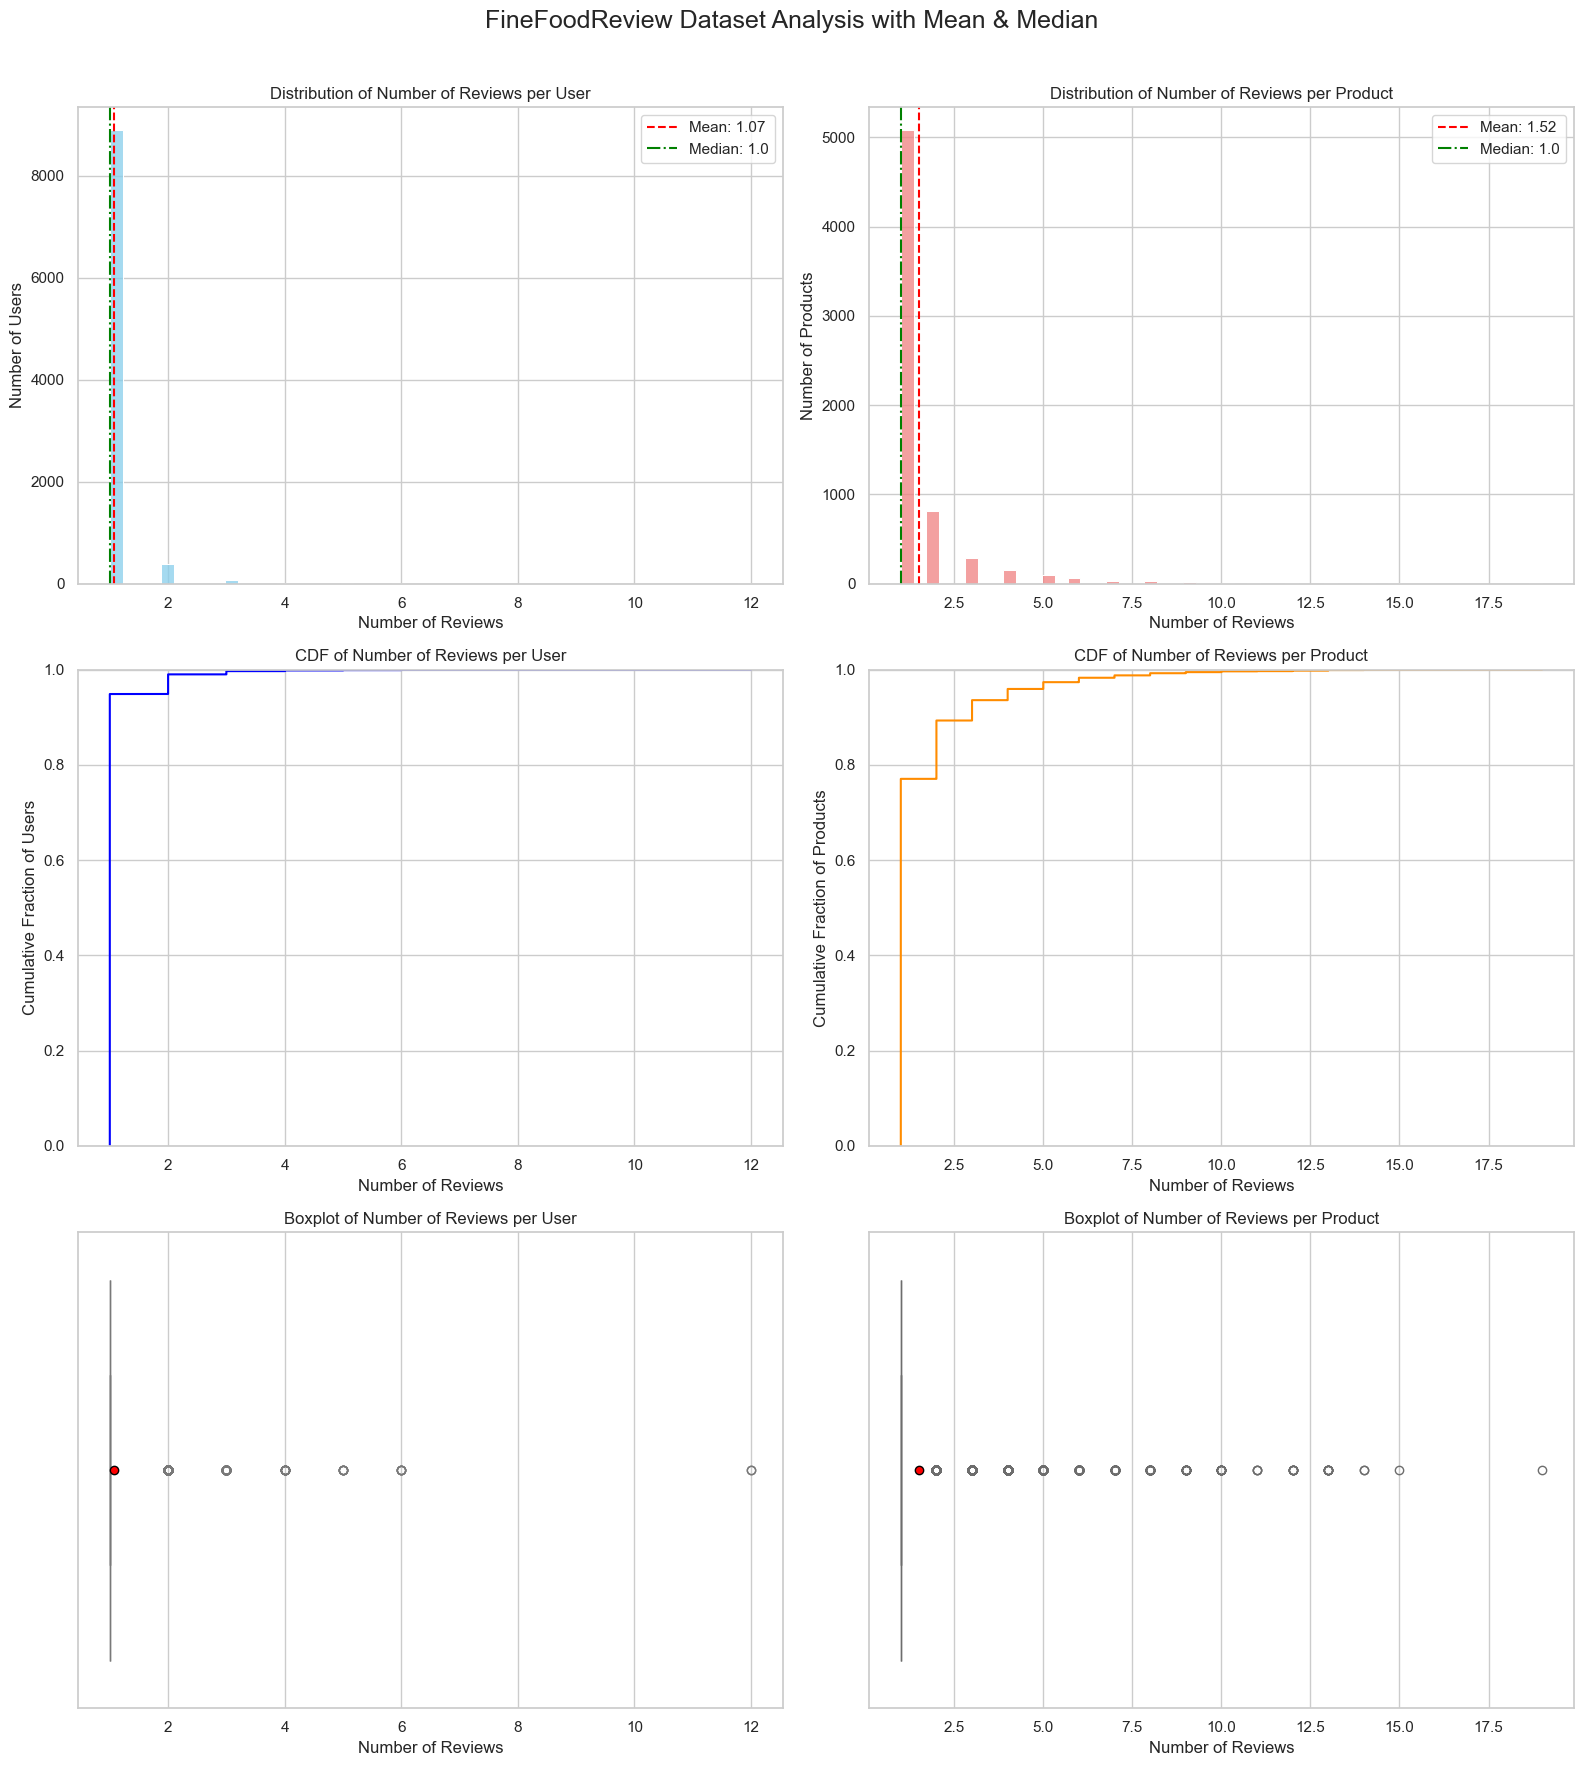

In [9]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("FineFoodReview Dataset Analysis with Mean & Median", fontsize=18)

# 1. Histogram of reviews per user
mean_u = grouped_by_user.mean()
median_u = grouped_by_user.median()
sns.histplot(grouped_by_user.to_numpy(), bins=50, ax=axes[0,0], color="skyblue", kde=False)
axes[0,0].axvline(mean_u, color="red", linestyle="--", label=f"Mean: {mean_u:.2f}")
axes[0,0].axvline(median_u, color="green", linestyle="-.", label=f"Median: {median_u}")
axes[0,0].set_title("Distribution of Number of Reviews per User")
axes[0,0].set_xlabel("Number of Reviews")
axes[0,0].set_ylabel("Number of Users")
axes[0,0].legend()

# 2. Histogram of reviews per product
mean_p = grouped_by_product.mean()
median_p = grouped_by_product.median()
sns.histplot(grouped_by_product.to_numpy(), bins=50, ax=axes[0,1], color="lightcoral", kde=False)
axes[0,1].axvline(mean_p, color="red", linestyle="--", label=f"Mean: {mean_p:.2f}")
axes[0,1].axvline(median_p, color="green", linestyle="-.", label=f"Median: {median_p}")
axes[0,1].set_title("Distribution of Number of Reviews per Product")
axes[0,1].set_xlabel("Number of Reviews")
axes[0,1].set_ylabel("Number of Products")
axes[0,1].legend()

# 3. CDF for users
sns.ecdfplot(grouped_by_user.to_numpy(), ax=axes[1,0], color="blue")
axes[1,0].set_title("CDF of Number of Reviews per User")
axes[1,0].set_xlabel("Number of Reviews")
axes[1,0].set_ylabel("Cumulative Fraction of Users")
axes[1,0].grid(True)


# 4. CDF for products
sns.ecdfplot(grouped_by_product.to_numpy(), ax=axes[1,1], color="darkorange")
axes[1,1].set_title("CDF of Number of Reviews per Product")
axes[1,1].set_xlabel("Number of Reviews")
axes[1,1].set_ylabel("Cumulative Fraction of Products")
axes[1,1].grid(True)

# 5. Boxplot for users
sns.boxplot(x=grouped_by_user, ax=axes[2,0], color="lightblue", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,0].set_title("Boxplot of Number of Reviews per User")
axes[2,0].set_xlabel("Number of Reviews")

# 6. Boxplot for products
sns.boxplot(x=grouped_by_product, ax=axes[2,1], color="salmon", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,1].set_title("Boxplot of Number of Reviews per Product")
axes[2,1].set_xlabel("Number of Reviews")

plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()




From the user and product statistics, we can see that the average number of reviews per user is around 2.22, with a maximum of 448 reviews by a single user. For products, the average number of reviews is about 7.66, with a maximum of 913 reviews for a single product. This indicates that while most users review only a few products, some users are very active in reviewing multiple products. Also, looking at the 75%, we can see that 75% of users have reviewed 2 or fewer products, and 75% of products have received 5 or fewer reviews. This suggests a long tail distribution where a few users and products are highly active while the majority are not. It's important to consider these statistics when training models, as they can impact the model's ability to generalize and the importance of certain users or products in the dataset. 


In [10]:
tokenizer = WordTokenizer(
            remove_stopwords=True,
            lower_case=True,
            use_lemmatization=True,
        )
def tokenize_reviews(input_df, tkz: WordTokenizer, forced = False):
    if forced or "TokenizedText" not in input_df.columns:
        input_df["TokenizedText"] = input_df["Text"].apply(lambda x: tkz(x, return_tokens=True))
    return input_df



In [11]:
tokenized_df = tokenize_reviews(df, tokenizer)
df = tokenized_df.copy(deep=True)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,"[tried, couple, brand, glutenfree, sandwich, c..."
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...,"[cat, love, treat, ever, find, house, pop, top..."
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...,"[little, less, expected, tends, muddy, taste, ..."
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","[first, frosted, miniwheats, original, size, f..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...,"[want, congratulate, graphic, artist, putting,..."
...,...,...,...,...,...,...,...,...,...,...,...
477825,477826,B004UC0GIU,A17OE0VPF9FO97,Norman D. Lund,7,7,4,1325721600,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an...","[frame, hold, weight, hold, nicely, rest, slig..."
414355,414356,B001ELJK78,A1Y4DROW97OXL4,Toivo,2,2,4,1262649600,Pleasantly suprised,I ordered this kit just to try it since the pr...,"[ordered, kit, try, since, price, good, making..."
553964,553965,B001E5E0D8,A2XSQDY34DMXTA,"SMA ""SA""",0,0,5,1248739200,Super coffee,This espresso is amazing. My wife would not dr...,"[espresso, amazing, wife, would, drink, coffee..."
471038,471039,B002HN2BM8,A2KGOD6XKLW2J8,"M. Morse ""Dita""",0,0,5,1311292800,Sweet!,I was so happy when I decided to look for Runt...,"[happy, decided, look, runt, amazon, able, fin..."


In [12]:
# store the new dataset with tokenized reviews to save time in future runs
df.to_csv("data/fine_food_reviews_tokenized.csv", index=False)

## TFIDF

In [13]:
df['JoinedTokens'] = df['TokenizedText'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['JoinedTokens'])

df['doc_vector_tfidf'] = list(X_tfidf.toarray())
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText,JoinedTokens,doc_vector_tfidf
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,"[tried, couple, brand, glutenfree, sandwich, c...",tried couple brand glutenfree sandwich cooky b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...,"[cat, love, treat, ever, find, house, pop, top...",cat love treat ever find house pop top bolt wh...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...,"[little, less, expected, tends, muddy, taste, ...",little less expected tends muddy taste expecte...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","[first, frosted, miniwheats, original, size, f...",first frosted miniwheats original size frosted...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...,"[want, congratulate, graphic, artist, putting,...",want congratulate graphic artist putting entir...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20786284..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
477825,477826,B004UC0GIU,A17OE0VPF9FO97,Norman D. Lund,7,7,4,1325721600,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an...","[frame, hold, weight, hold, nicely, rest, slig...",frame hold weight hold nicely rest slightly fl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
414355,414356,B001ELJK78,A1Y4DROW97OXL4,Toivo,2,2,4,1262649600,Pleasantly suprised,I ordered this kit just to try it since the pr...,"[ordered, kit, try, since, price, good, making...",ordered kit try since price good making wine y...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
553964,553965,B001E5E0D8,A2XSQDY34DMXTA,"SMA ""SA""",0,0,5,1248739200,Super coffee,This espresso is amazing. My wife would not dr...,"[espresso, amazing, wife, would, drink, coffee...",espresso amazing wife would drink coffee produ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
471038,471039,B002HN2BM8,A2KGOD6XKLW2J8,"M. Morse ""Dita""",0,0,5,1311292800,Sweet!,I was so happy when I decided to look for Runt...,"[happy, decided, look, runt, amazon, able, fin...",happy decided look runt amazon able find store...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
kmeans_tfidf = KMeans(n_clusters=5, random_state=random_state)
df['Cluster_TFIDF'] = kmeans_tfidf.fit_predict(X_tfidf)

In [15]:
df.to_csv("data/vectorized_reviews.csv", index=False)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TokenizedText,JoinedTokens,doc_vector_tfidf,Cluster_TFIDF
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,"[tried, couple, brand, glutenfree, sandwich, c...",tried couple brand glutenfree sandwich cooky b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...,"[cat, love, treat, ever, find, house, pop, top...",cat love treat ever find house pop top bolt wh...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...,"[little, less, expected, tends, muddy, taste, ...",little less expected tends muddy taste expecte...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","[first, frosted, miniwheats, original, size, f...",first frosted miniwheats original size frosted...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...,"[want, congratulate, graphic, artist, putting,...",want congratulate graphic artist putting entir...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20786284...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477825,477826,B004UC0GIU,A17OE0VPF9FO97,Norman D. Lund,7,7,4,1325721600,"Frame is great, rest is flimsy - Thankfully th...","The frame of this is what holds the weight, an...","[frame, hold, weight, hold, nicely, rest, slig...",frame hold weight hold nicely rest slightly fl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
414355,414356,B001ELJK78,A1Y4DROW97OXL4,Toivo,2,2,4,1262649600,Pleasantly suprised,I ordered this kit just to try it since the pr...,"[ordered, kit, try, since, price, good, making...",ordered kit try since price good making wine y...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
553964,553965,B001E5E0D8,A2XSQDY34DMXTA,"SMA ""SA""",0,0,5,1248739200,Super coffee,This espresso is amazing. My wife would not dr...,"[espresso, amazing, wife, would, drink, coffee...",espresso amazing wife would drink coffee produ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
471038,471039,B002HN2BM8,A2KGOD6XKLW2J8,"M. Morse ""Dita""",0,0,5,1311292800,Sweet!,I was so happy when I decided to look for Runt...,"[happy, decided, look, runt, amazon, able, fin...",happy decided look runt amazon able find store...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


## Clustering

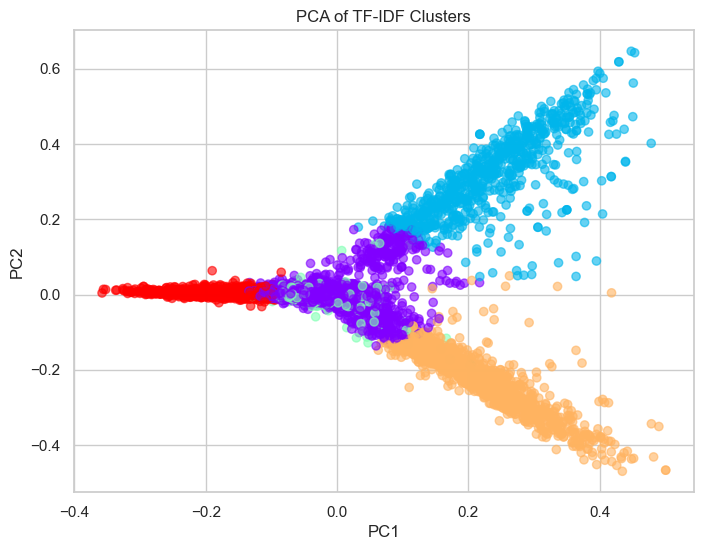

In [16]:
from sklearn.decomposition import PCA

X_tfidf_dense = X_tfidf.toarray()
X_tfidf_pca = PCA(n_components=2).fit_transform(X_tfidf_dense)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X_tfidf_pca[:,0], X_tfidf_pca[:,1], c=df['Cluster_TFIDF'], cmap='rainbow', alpha=0.6)
plt.title("PCA of TF-IDF Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [17]:
for i in range(5):
    print(f"\nTF-IDF Cluster {i}")
    print(df[df['Cluster_TFIDF'] == i]['TokenizedText'].sample(3, random_state=random_state).values)



TF-IDF Cluster 0
[list(['oat', 'flour', 'good', 'source', 'protein', 'fiber', 'worked', 'fine', 'homemade', 'bread', 'along', 'white', 'wheat', 'flour', 'nicely', 'flavored', 'light', 'textured', 'like', 'much', 'crepe', 'flour', 'used', 'worked', 'great', 'place', 'white', 'flour', 'high', 'altitude', 'brownie', 'mix', 'instruction', 'like', 'bob', 'red', 'mill', 'high', 'quality', 'productswe', 'amazon', 'prime', 'order', 'arrived', 'quickly', 'amazon', 'prime', 'delightful', 'highly', 'recommend'])
 list(['received', 'good', 'condition', 'timely', 'manner', 'great', 'relaxing', 'heart'])
 list(['product', 'kill', 'ant', 'advertised', 'want', 'carpenter', 'ant', 'house', 'sure', 'insect', 'like', 'either'])]

TF-IDF Cluster 1
[list(['enjoy', 'variety', 'yogi', 'tea', 'really', 'enjoying', 'flavor', 'tea', 'normally', 'squeeze', 'lemon', 'green', 'tea', 'enjoy', 'taste', 'without', 'sugar', 'honey', 'tea', 'due', 'hint', 'blueberry', 'need', 'help', 'stock', 'say', 'anything', 'slimm

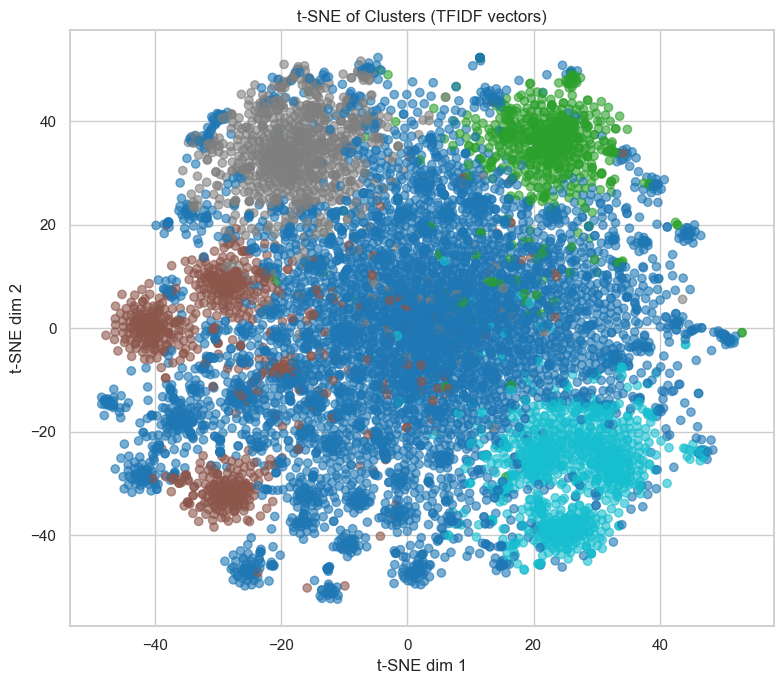

In [ ]:
# t-SNE 

# Run t-SNE on TFIDF vectors
tsne_tfidf = TSNE(n_components=2, random_state=random_state, perplexity=30, max_iter=1000, init='random')
X_tsne_tfidf = tsne_tfidf.fit_transform(X_tfidf)

# Plot TFIDF t-SNE
plt.figure(figsize=(8, 7))
plt.scatter(X_tsne_tfidf[:,0], X_tsne_tfidf[:,1], c=df['Cluster_TFIDF'], cmap='tab10', alpha=0.6)
plt.title("t-SNE of Clusters (TFIDF vectors)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()


/Users/mark/miniconda3/envs/csca-5632-final-project/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


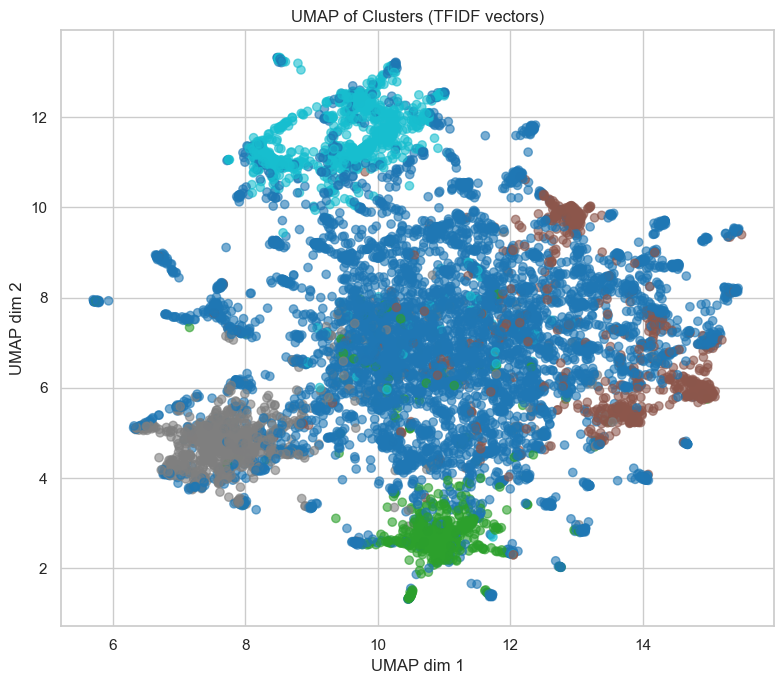

In [21]:
# Plot only TFIDF UMAP
umap_tfidf = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=random_state)
X_umap_tfidf = umap_tfidf.fit_transform(X_tfidf)
plt.figure(figsize=(8, 7))
plt.scatter(X_umap_tfidf[:,0], X_umap_tfidf[:,1], c=df['Cluster_TFIDF'], cmap='tab10', alpha=0.6)
plt.title("UMAP of Clusters (TFIDF vectors)")
plt.xlabel("UMAP dim 1")
plt.ylabel("UMAP dim 2")
plt.tight_layout()
plt.show()


In [ ]:
def top_tfidf_words_per_cluster(tfidf_matrix, labels, vectorizer, cluster, n=10):
    indices = np.where(labels == cluster)[0]
    # Compute mean vector for the cluster
    cluster_tfidf = tfidf_matrix[indices].mean(axis=0)
    # Convert to 1D array if needed
    if hasattr(cluster_tfidf, 'A1'):
        cluster_tfidf = cluster_tfidf.A1
    else:
        cluster_tfidf = np.array(cluster_tfidf).flatten()
    # Get top n indices
    top_n = np.argsort(cluster_tfidf)[::-1][:n]
    res = [vectorizer.get_feature_names_out()[i] for i in top_n]
    return res

for i in range(5):
    print(f"\nCluster {i} top TFIDF words:\n", 
          top_tfidf_words_per_cluster(X_tfidf, df['Cluster_TFIDF'], vectorizer, i))


Cluster 0 top TFIDF words:
 ['product', 'taste', 'great', 'good', 'like', 'flavor', 'love', 'price', 'time', 'make']

Cluster 1 top TFIDF words:
 ['tea', 'green', 'taste', 'flavor', 'bag', 'drink', 'like', 'cup', 'good', 'black']

Cluster 2 top TFIDF words:
 ['chocolate', 'bar', 'chip', 'like', 'taste', 'flavor', 'good', 'great', 'snack', 'love']

Cluster 3 top TFIDF words:
 ['coffee', 'cup', 'like', 'strong', 'flavor', 'good', 'taste', 'roast', 'bold', 'great']

Cluster 4 top TFIDF words:
 ['dog', 'food', 'cat', 'treat', 'love', 'eat', 'like', 'product', 'chew', 'good']
